In [1]:
import random
import sklearn
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
#from torch.utils.data import DataLoader

# Helper Functions

In [2]:
def findLocAlter(wavelength,signal,start_wave, end_wave):
    if len(wavelength) != len(signal):
        raise ValueError("The size of the first array must be the same as the second array.")
    if start_wave >= end_wave:
        raise ValueError("The start_wave is bigger or same with end_wave.")

    start_index = np.argmax(wavelength >= start_wave)
    end_index = np.argmax(wavelength >= end_wave ) 
    if end_index == 0: end_index=len(wavelength)
    cut_array = signal[start_index:end_index ]
    
    return cut_array

# Load Dataset & Build Dataloader

In [3]:
def get_caseset(Path='./'):
    caseset= pd.read_excel(Path+'case.xlsx')
    return caseset

def get_dataset(Path='./rawdata'):
    dataset=[]
    testdataset=[]
    for name in [chr(i) for i in range(ord('A'), ord('J')+1)]:
        for number in range(1,5+1):
            dataset.append(np.array(pd.read_table(Path+'/case'+name+str(number)+'X.txt', sep = "\s+", skipinitialspace=True))[:,1:])
    wavelength=np.array(pd.read_table(Path+'/case'+name+str(number)+'X.txt', sep = "\s+", skipinitialspace=True))[:,0]

    name='K'
    for number in range(1,30+1):
        testdataset.append(np.array(pd.read_table(Path+'/case'+name+str(number)+'X.txt', sep = "\s+", skipinitialspace=True))[:,1:])
    
    return wavelength, dataset, testdataset

def get_processeddataset(Path='./rawdata'):
    removepoint=np.array([204,684,1164,1300,1445,1513,1632,1924])-1

    wavelength, dataset, testdataset = get_dataset(Path)
    background = np.array(pd.read_table(Path+'/caseX0X.txt', sep = "\s+", skipinitialspace=True))  
    avgbackground = np.mean(background[:,1:],1)
    processed_dataset=[]
    processed_testdataset=[]
    for element in dataset:
        temp_dark = element-avgbackground[:, np.newaxis]
        temp_data = temp_dark-np.mean(findLocAlter(background[:,0],temp_dark,200,210))
        processed_dataset.append(np.delete(temp_data,removepoint, axis=0))
    for element in testdataset:
        temp_dark=element-avgbackground[:, np.newaxis]
        temp_data = temp_dark-np.mean(findLocAlter(background[:,0],temp_dark,200,210))
        processed_testdataset.append(np.delete(temp_data,removepoint, axis=0))
    processed_wave=np.delete(wavelength,removepoint, axis=0)

    return processed_wave, processed_dataset, processed_testdataset

def peak_normalized(wv,sig):
    peakdata=[]
    normalized_signal=[]
    for signal in sig:
        meanpeakvalue=np.mean(findLocAlter(wv,signal,306.5,313),0)
        peakdata.append(meanpeakvalue)
        normalized_signal.append(signal/meanpeakvalue)

    return normalized_signal, peakdata


def area_normalized(wv,sig):
    areadata=[]
    normalized_signal=[]
    for signal in sig:
        areavalue=np.trapz(signal, axis=0)
        areadata.append(areavalue)
        normalized_signal.append(signal/areavalue)

    return normalized_signal, areadata

def make_figure(wv,casenum,sig):
    plt.figure()
    colors=np.array([[84, 13, 110],[ 14, 173, 105],[216, 6, 65],[81, 103, 245],[237,175,33]])/255
    j=0
    for i in casenum:
        plt.plot(wv, np.mean(sig[i],1),color=colors[j], label=f'Data Point {i + 1}')
        j+=1
    plt.xlabel("Wavelength (nm)",{'size':14,'fontname':'Times New Roman'})
    plt.ylabel("Signal (a.u.)",{'size':14,'fontname':'Times New Roman'})
    plt.legend( loc=0, framealpha=0.5)
    return


# Visualize Dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


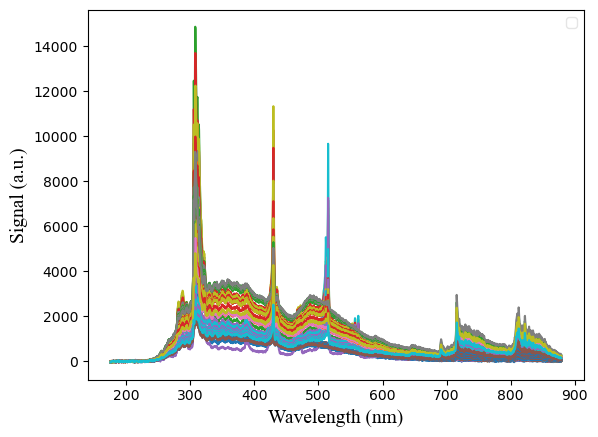

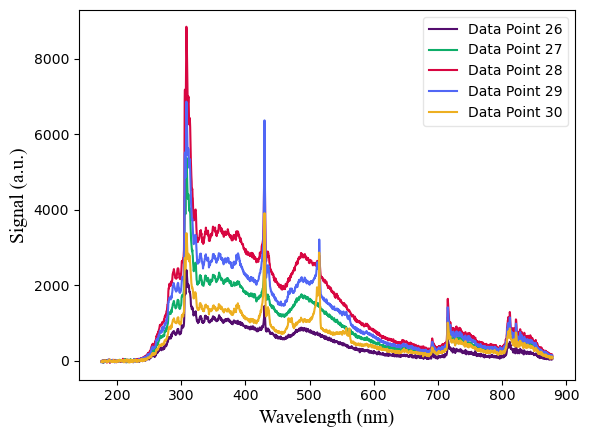

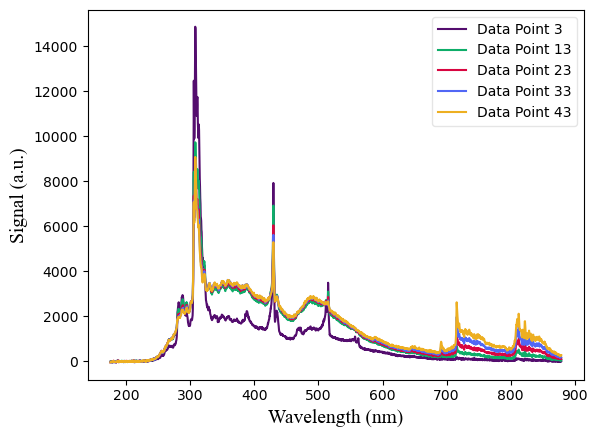

In [4]:
caseset=get_caseset()
wv, sig, testsig = get_processeddataset()

plt.figure(0)
for signal in sig:
    plt.plot(wv, np.mean(signal,1))
plt.xlabel("Wavelength (nm)",{'size':14,'fontname':'Times New Roman'})
plt.ylabel("Signal (a.u.)",{'size':14,'fontname':'Times New Roman'})
plt.legend( loc=0, framealpha=0.5)

make_figure(wv,[25,26,27,28,29],sig)
make_figure(wv,[2,12,22,32,42],sig)

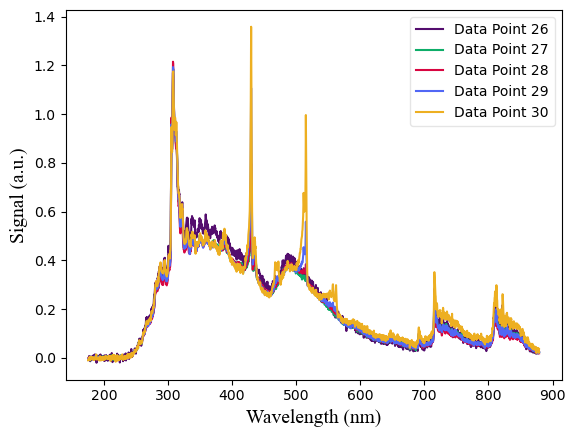

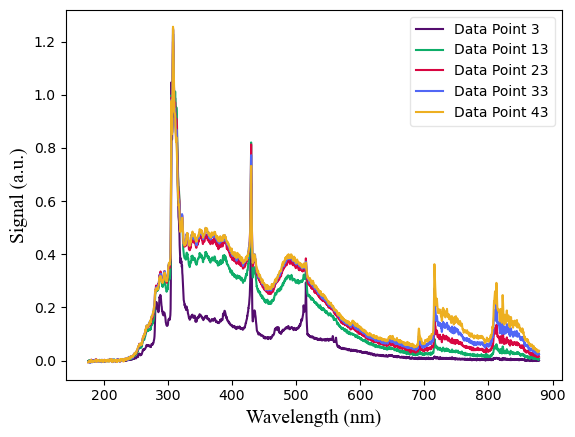

In [5]:
normalized_signal,peakdata=peak_normalized(wv,sig)
make_figure(wv,[25,26,27,28,29],normalized_signal)
make_figure(wv,[2,12,22,32,42],normalized_signal)


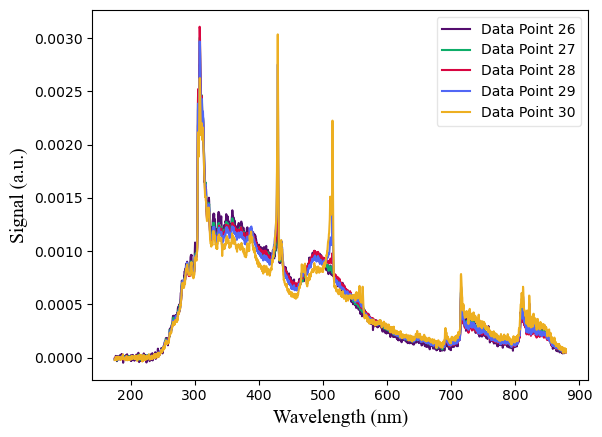

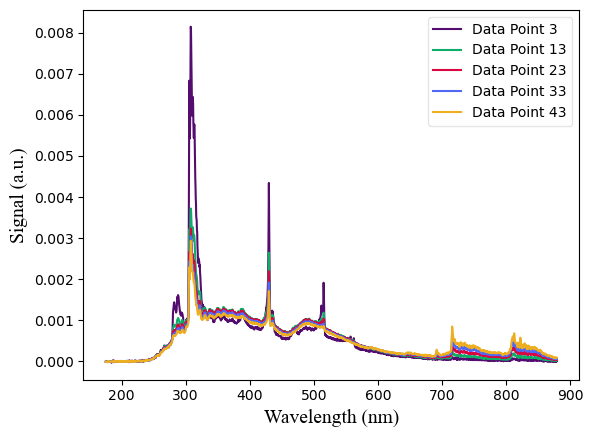

In [6]:
normalized_signal,areadata=area_normalized(wv,sig)
make_figure(wv,[25,26,27,28,29],normalized_signal)
make_figure(wv,[2,12,22,32,42],normalized_signal)

# Dimension Reduction Process

In [7]:
import sklearn.decomposition

def PCA(snapshot: np.array, ncomp = 0.1):
    pca = sklearn.decomposition.PCA(n_components=ncomp,svd_solver = 'full')
    pca.fit(snapshot)
    return pca

## Sample dimension reduction

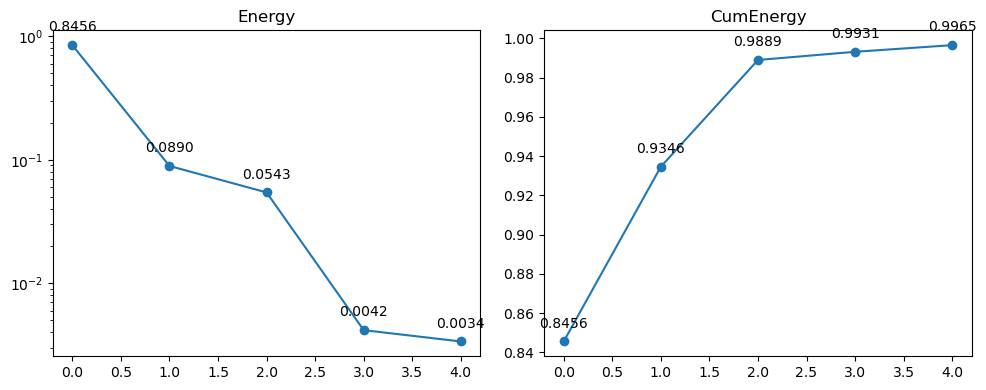

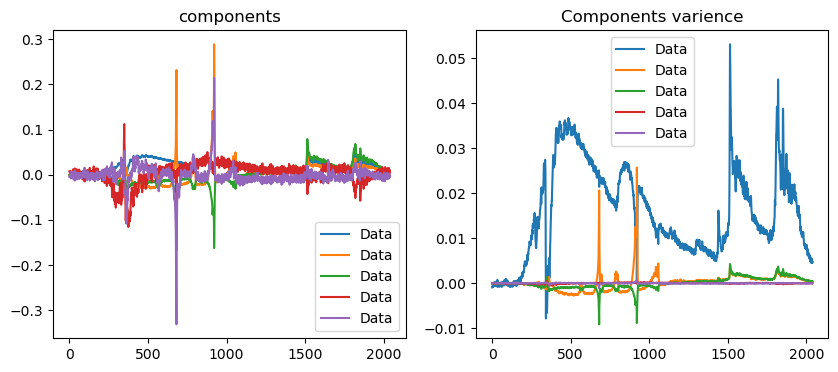

In [8]:
normalized_signal,peakdata=peak_normalized(wv,sig)
snapshot=np.mean(normalized_signal,2).T
#snapshot=np.hstack(np.stack(normalized_signal))
RD=PCA(snapshot.T,5)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed
axs[0].semilogy(RD.explained_variance_ratio_,marker='o')
axs[0].set_title('Energy')
for i, yi in enumerate(RD.explained_variance_ratio_):
    axs[0].annotate(f'{yi:.4f}', (i, yi), textcoords="offset points", xytext=(0,10), ha='center')

axs[1].plot(np.cumsum(RD.explained_variance_ratio_),marker='o')
axs[1].set_title('CumEnergy')
for i, yi in enumerate(np.cumsum(RD.explained_variance_ratio_)):
    axs[1].annotate(f'{yi:.4f}', (i, yi), textcoords="offset points", xytext=(0,10), ha='center')
plt.tight_layout()

sum(RD.explained_variance_ratio_)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Adjust figsize as needed
axs[0].plot(RD.components_.T, label='Data')
axs[0].set_title('components')
axs[0].legend()
axs[1].plot(RD.components_.T*RD.explained_variance_ratio_, label='Data')
axs[1].set_title('Components varience')
axs[1].legend()

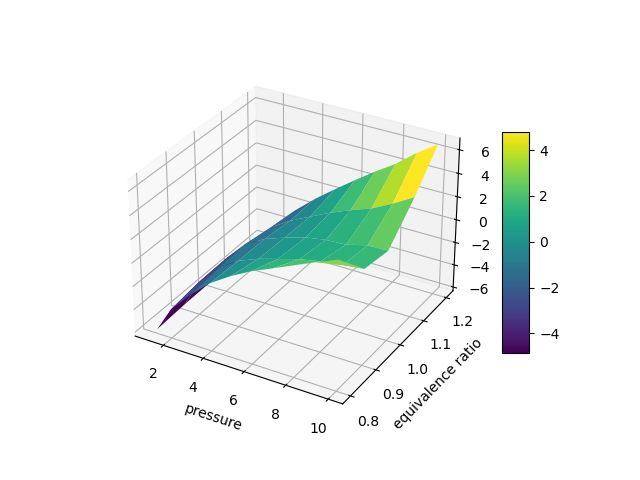

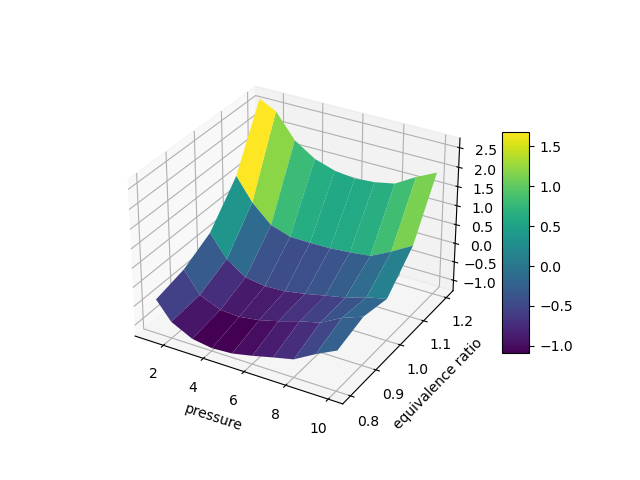

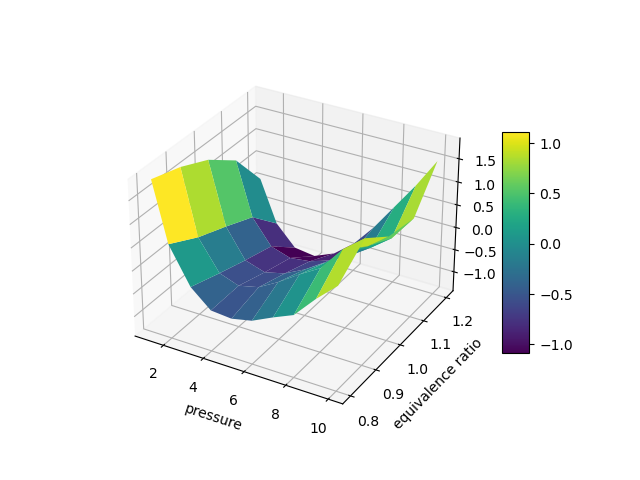

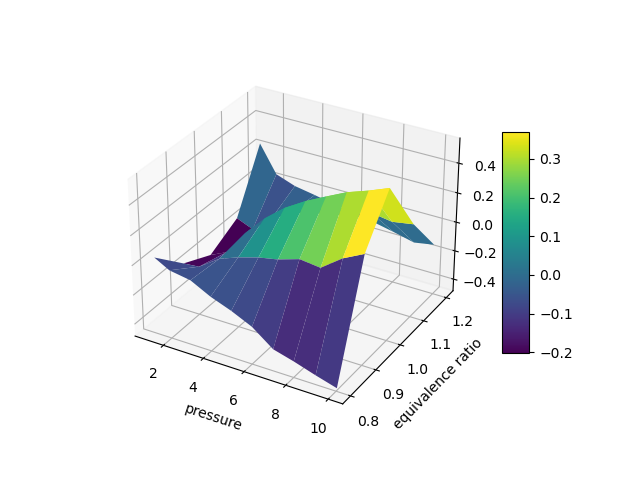

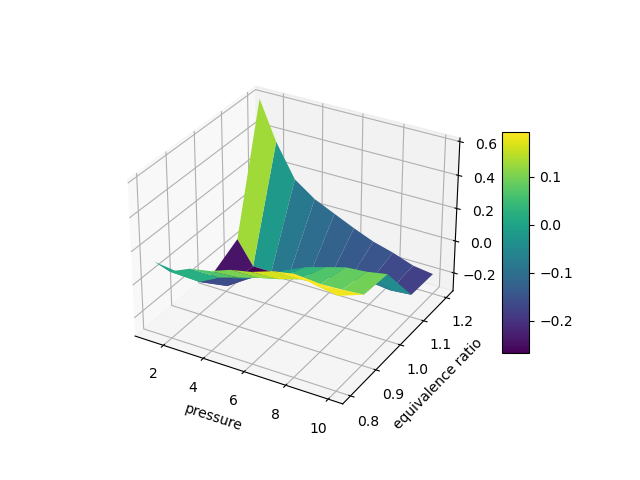

In [9]:
%matplotlib widget
 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

X=RD.transform(snapshot.T)
y=np.array(caseset.iloc[ 0:50 , 0:2])


for i in range(5):
    # creating figure
    fig = plt.figure()
    ax = Axes3D(fig)
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(y[:,0].reshape(10,5), y[:,1].reshape(10,5), X[:,i].reshape(10,5), cmap='viridis')
    ax.set_xlabel('pressure')
    ax.set_ylabel('equivalence ratio')
    ax.set_zlabel('Component_{}'.format(i))
    #ax.set_zlim(-5, 5)
    #ax.set_xticks([-10, -5, 0, 5, 10])
    #ax.set_yticks([-10, -5, 0, 5, 10])
    #ax.set_zticks([-5, 0, 5])

    fig.colorbar(surf, shrink=0.6, aspect=8)

## Regression process

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
#np.hstack(normalized_signal).T

X=RD.transform(snapshot.T)
caseset=get_caseset()
y=np.array(caseset.iloc[ 0:50 , 0:2])
#anistropic kernel
kernel = RBF(length_scale=[0.01, 0.01, 0.01, 0.01, 0.01], length_scale_bounds=[(1e-1, 100.0), (1e-1, 10.0),(1e-1, 10.0), (1e-1, 10.0),(1e-1, 10.0)])
#kernel = 1.0*RBF(length_scale=0.1, length_scale_bounds=(1e-6, 1000e-1))
gpr = GaussianProcessRegressor(kernel=kernel,random_state=2, normalize_y=1, n_restarts_optimizer=10).fit(X, y)


print(gpr.kernel_)
print(gpr.kernel.hyperparameters)
print(gpr.kernel.theta)

c:\Users\Taekeun\anaconda3\envs\Robcal\Lib\site-packages\sklearn\utils\_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


RBF(length_scale=[4.18, 1.86, 3.24, 0.259, 0.675])
[Hyperparameter(name='length_scale', value_type='numeric', bounds=array([[  0.1, 100. ],
       [  0.1,  10. ],
       [  0.1,  10. ],
       [  0.1,  10. ],
       [  0.1,  10. ]]), n_elements=5, fixed=False)]
[-4.60517019 -4.60517019 -4.60517019 -4.60517019 -4.60517019]


C:\Users\Taekeun\AppData\Local\Temp\ipykernel_429040\3850283955.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Case_test[:,0], Case_test[:,1], testsnapshot_predict[:,0], cmap='viridis')
C:\Users\Taekeun\AppData\Local\Temp\ipykernel_429040\3850283955.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Case_test[:,0], Case_test[:,1], testsnapshot_predict[:,1], cmap='viridis')


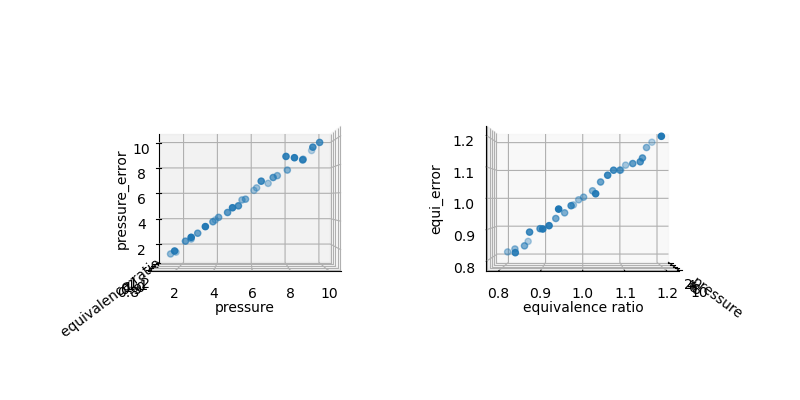

In [15]:
A=np.array(caseset.iloc[ 0:50 , 0:2])
y=A
fig = plt.figure( figsize=(8, 4))
ax = Axes3D(fig)
ax = fig.add_subplot(121, projection='3d')
snapshot_predict=gpr.predict(RD.transform(snapshot.T))#-A)/A

Case_test=np.array(caseset.iloc[ 50:80 , 0:2])
test_signal,peakdata=peak_normalized(wv,testsig)
B=np.mean(np.array(test_signal),axis=2)
test_predict=gpr.predict(RD.transform(B))
testsnapshot_predict=test_predict#-Case_test)/Case_test


surf = ax.plot_surface(y[:,0].reshape(10,5), y[:,1].reshape(10,5), snapshot_predict[:,0].reshape(10,5), cmap='viridis')
ax.scatter(Case_test[:,0], Case_test[:,1], testsnapshot_predict[:,0], cmap='viridis')
ax.set_xlabel('pressure')
ax.set_ylabel('equivalence ratio')
ax.set_zlabel('pressure_error')
ax.view_init(elev=0, azim=-90)
#ax.set_zlim(-0.001, 0.001)

ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(y[:,0].reshape(10,5), y[:,1].reshape(10,5), snapshot_predict[:,1].reshape(10,5), cmap='viridis')
ax.scatter(Case_test[:,0], Case_test[:,1], testsnapshot_predict[:,1], cmap='viridis')
ax.set_xlabel('pressure')
ax.set_ylabel('equivalence ratio')
ax.set_zlabel('equi_error')
ax.view_init(elev=0, azim=0)
#ax.set_zlim(-0.001, 0.001)



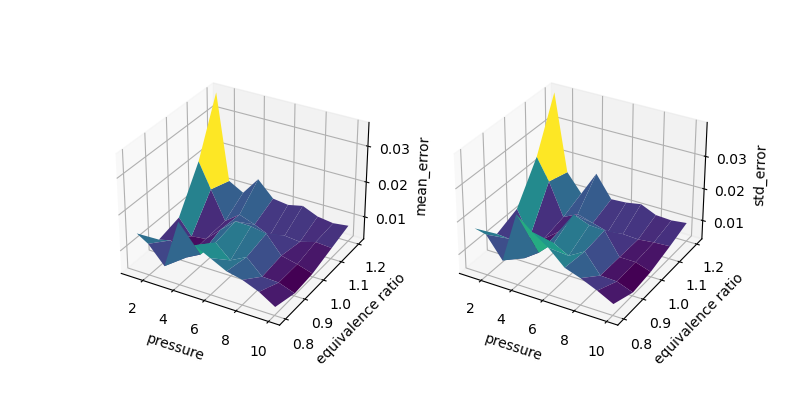

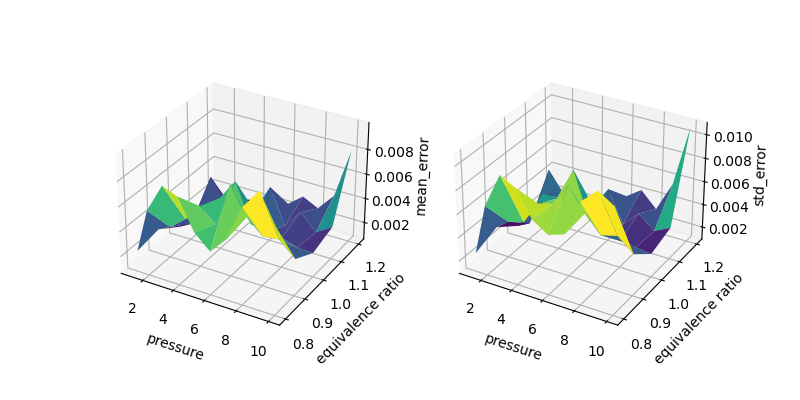

In [16]:

signal,peakdata=peak_normalized(wv,sig)
B=np.hstack(signal)
train_predict=gpr.predict(RD.transform(B.T))

# Reshape the data into groups of 10 elements
num_groups = train_predict.shape[0] // 10
data_reshaped = train_predict[:num_groups * 10].reshape(num_groups, 10, 2)

# Calculate mean and standard deviation for each group along the second axis (axis=1)
C=np.tile(A[:,np.newaxis,:],(1,10,1))
train_mean = np.mean(np.abs(data_reshaped-C)/C, axis=1)
train_std = np.std(data_reshaped, axis=1)/A

for i in range(2):
    fig = plt.figure( figsize=(8, 4))
    ax = Axes3D(fig)
    ax = fig.add_subplot(121, projection='3d')

    surf = ax.plot_surface(y[:,0].reshape(10,5), y[:,1].reshape(10,5), train_mean[:,i].reshape(10,5), cmap='viridis')
    ax.set_xlabel('pressure')
    ax.set_ylabel('equivalence ratio')
    ax.set_zlabel('mean_error')

    ax = fig.add_subplot(122, projection='3d')
    surf = ax.plot_surface(y[:,0].reshape(10,5), y[:,1].reshape(10,5), train_std[:,i].reshape(10,5), cmap='viridis')
    ax.set_xlabel('pressure')
    ax.set_ylabel('equivalence ratio')
    ax.set_zlabel('std_error')
